In [44]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import datetime, os
import imageio as imio
from skimage import color
from skimage.transform import resize

In [4]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="flower_photos.tgz", 
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')


In [5]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [6]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 5))

In [7]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [8]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 2s 0us/step


In [9]:
base_model.trainable = False

In [10]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

In [11]:
model.summary( )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [16]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables))) 

Number of trainable variables = 4


In [17]:
epochs = 10

history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data=val_generator)

Train for 46 steps, validate for 12 steps
Epoch 1/10
46/46 [==============================] - 560s 12s/step - loss: 0.9680 - accuracy: 0.6247 - val_loss: 1.1889 - val_accuracy: 0.6170
Epoch 2/10
46/46 [==============================] - 556s 12s/step - loss: 0.4083 - accuracy: 0.8629 - val_loss: 0.7852 - val_accuracy: 0.7415
Epoch 3/10
16/46 [=========>....................] - ETA: 5:24 - loss: 0.2603 - accuracy: 0.9156

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [ ]:
history_fine = model.fit_generator(train_generator, 
                         epochs=5,
                         validation_data=val_generator)

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
model.save('Flowers_model.h5')

In [45]:
model = tf.keras.models.load_model('model.tflite')

OSError: SavedModel file does not exist at: model.tflite/{saved_model.pbtxt|saved_model.pb}

In [36]:
img = imio.imread('testimage1.jpg')
img.shape

(502, 790, 3)

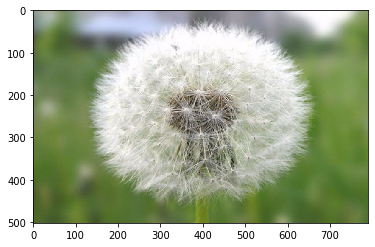

In [37]:
plt.imshow(img)

In [38]:
img = resize(img, (224, 224))
img = img.reshape(224, 224, 3)
img = np.expand_dims(img,0)
img.shape

(1, 224, 224, 3)

In [39]:
predictions_single = model.predict(img)
res= np.argmax(predictions_single)
print(predictions_single)

[[6.9186381e-06 9.9999309e-01 2.0158937e-10 1.6610098e-08 6.8148431e-10]]


In [40]:
if res == 0:
    print('С вероятностью', np.max(predictions_single), 'это ромашка')
elif res == 1:
    print('С вероятностью', np.max(predictions_single), 'это одуванчик')
elif res == 2:
    print('С вероятностью', np.max(predictions_single), 'это роза')
elif res == 3:
    print('С вероятностью', np.max(predictions_single), 'это подсолнух')
elif res == 4:
    print('С вероятностью', np.max(predictions_single), 'это тюльпан')

С вероятностью 0.9999931 это одуванчик
